In [86]:
import os
import pandas as pd

# Get the current working directory
cwd = os.getcwd()
print(cwd)
os.chdir("/home/kurowskik/transfer_learning/")

/home/kurowskik/transfer_learning


In [218]:
# for reproducibility
np.random.seed(3768)

# use this environment flag to change which GPU to use 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"  # specify which GPU(s) to be used

#Get TensorFlow session
def get_session(): 
    config = tf.ConfigProto() 
    config.gpu_options.allow_growth = True
    return tf.Session(config=config) 
  
# One hot encoding of labels 
def dense_to_one_hot(labels_dense,num_clases=4):
    return np.eye(num_clases)[labels_dense]

In [42]:
from __future__ import print_function

import numpy as np
from random import shuffle
import time
import csv
from PIL import Image
import os
import tensorflow as tf
import keras
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras import initializers
from keras.optimizers import SGD
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential,load_model,Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import *
from keras.callbacks import CSVLogger
from keras import callbacks
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import sklearn.metrics as sklm
from utils import lossprettifier
from Classifier import VGG
from Classifier.VGG import *

/home/kurowskik/wbiad3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kurowskik/wbiad3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kurowskik/wbiad3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kurowskik/wbiad3.6/lib/python3.6/site-packages/tensorflow/python/frame

ModuleNotFoundError: No module named 'utils'

In [29]:
names = pd.read_csv("data/names.vim", header = None, dtype = str)

In [16]:
data = pd.read_csv("Data_Entry_2017_v2020.csv")

In [18]:
data

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168
...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,38,M,PA,2048,2500,0.168,0.168
112116,00030802_000.png,No Finding,0,30802,28,M,PA,2048,2500,0.168,0.168
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168
112118,00030804_000.png,No Finding,0,30804,29,F,PA,2048,2500,0.168,0.168


In [27]:
data["Image Index"]

0         00000001_000.png
1         00000001_001.png
2         00000001_002.png
3         00000002_000.png
4         00000003_001.png
                ...       
112115    00030801_001.png
112116    00030802_000.png
112117    00030803_000.png
112118    00030804_000.png
112119    00030805_000.png
Name: Image Index, Length: 112120, dtype: object

In [33]:
names.values.flatten()

array(['00000001_000.png', '00000001_001.png', '00000001_002.png', ...,
       '00001335_004.png', '00001335_005.png', '00001335_006.png'],
      dtype=object)

In [34]:
data_filtered = data[ data["Image Index"].isin( names.values.flatten()) ]

In [35]:
data_filtered

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168
...,...,...,...,...,...,...,...,...,...,...,...
4994,00001335_002.png,No Finding,2,1335,18,F,PA,2048,2500,0.168,0.168
4995,00001335_003.png,No Finding,3,1335,19,F,PA,2048,2500,0.168,0.168
4996,00001335_004.png,No Finding,4,1335,19,F,PA,2992,2991,0.143,0.143
4997,00001335_005.png,No Finding,5,1335,22,F,PA,2946,2948,0.143,0.143


In [37]:
vals_to_train = data_filtered[ ["Image Index", "Patient Gender"]]
vals_to_train

,Image Index,Patient Gender
0,00000001_000.png,M
1,00000001_001.png,M
2,00000001_002.png,M
3,00000002_000.png,M
4,00000003_001.png,F
...,...,...
4994,00001335_002.png,F
4995,00001335_003.png,F
4996,00001335_004.png,F
4997,00001335_005.png,F


In [45]:
def readTestImage(img_path): 
    img = Image.open(img_path) #open image you want to visualize "1238_R.png"

    img = np.array(img.resize((224,224), Image.ANTIALIAS))
    imgArr = img.reshape(1,224,224,3)#open image you want to visualize
    imgNormalized = imgArr / 255.
    
    return img, imgArr, imgNormalized

In [40]:
X = vals_to_train[["Image Index"]]
y = vals_to_train[["Patient Gender"]]

In [43]:
# Preparing training and test sets
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.10, random_state=42)

In [87]:
img_path = os.path.join("data", "images")

def load_images(names):
    n_images = len(names)
    images = np.zeros((n_images, 224, 224, 3))
    labels = np.empty(n_images, dtype='object')
    for i in range(n_images):
        name = names[i]
        print(name)
        image = Image.open(os.path.join(img_path, name))
        image = image.convert('RGB').resize((224,224)) #thumbnail
        image = np.asarray(image)
        images[i] = image
        labels[i] = dict_train[name]
    return images, labels

In [96]:
test = df["Image Index"][0]

'00000001_000.png'

In [98]:
X_train, y_train = load_images( [df["Image Index"][0] ])

00000001_000.png


In [137]:
df

,Image Index,Patient Gender
0,00000001_000.png,1
1,00000001_001.png,1
2,00000001_002.png,1
3,00000002_000.png,1
4,00000003_001.png,1
...,...,...
4993,00001335_001.png,1
4994,00001335_002.png,1
4996,00001335_004.png,1
4997,00001335_005.png,1


In [59]:
def encode(x):
    if x == "M":
        return 0
    else:
        return 1

In [112]:
vals_to_train[ vals_to_train["Image Index"].isin( x_valid.values.flatten()) ]

,Image Index,Patient Gender
8,00000003_005.png,F
12,00000004_000.png,M
23,00000008_000.png,F
26,00000009_000.png,M
29,00000011_001.png,M
...,...,...
4967,00001326_000.png,F
4974,00001328_000.png,F
4987,00001333_001.png,M
4989,00001334_001.png,F


In [198]:
df2 = vals_to_train[ vals_to_train["Image Index"].isin( x_valid.values.flatten()) ]
df2["Patient Gender"] = df2["Patient Gender"].map( encode)

/home/kurowskik/wbiad3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [199]:
df2

,Image Index,Patient Gender
8,00000003_005.png,1
12,00000004_000.png,0
23,00000008_000.png,1
26,00000009_000.png,0
29,00000011_001.png,0
...,...,...
4967,00001326_000.png,1
4974,00001328_000.png,1
4987,00001333_001.png,0
4989,00001334_001.png,1


In [200]:
y_val = df2["Patient Gender"] 

In [201]:
y_val

8       1
12      0
23      1
26      0
29      0
       ..
4967    1
4974    1
4987    0
4989    1
4995    1
Name: Patient Gender, Length: 500, dtype: int64

In [176]:
X_train

array([[[[193., 193., 193.],
         [187., 187., 187.],
         [172., 172., 172.],
         ...,
         [  5.,   5.,   5.],
         [  5.,   5.,   5.],
         [  3.,   3.,   3.]],

        [[185., 185., 185.],
         [169., 169., 169.],
         [121., 121., 121.],
         ...,
         [  5.,   5.,   5.],
         [  5.,   5.,   5.],
         [  3.,   3.,   3.]],

        [[168., 168., 168.],
         [122., 122., 122.],
         [ 57.,  57.,  57.],
         ...,
         [  4.,   4.,   4.],
         [  5.,   5.,   5.],
         [  3.,   3.,   3.]],

        ...,

        [[253., 253., 253.],
         [230., 230., 230.],
         [185., 185., 185.],
         ...,
         [  1.,   1.,   1.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[254., 254., 254.],
         [231., 231., 231.],
         [184., 184., 184.],
         ...,
         [  4.,   4.,   4.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[255., 255., 255.],
       

In [196]:
df = vals_to_train[ vals_to_train["Image Index"].isin( x_train.values.flatten()) ]
df["Patient Gender"] = df["Patient Gender"].map( encode)

/home/kurowskik/wbiad3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [197]:
df

,Image Index,Patient Gender
0,00000001_000.png,0
1,00000001_001.png,0
2,00000001_002.png,0
3,00000002_000.png,0
4,00000003_001.png,1
...,...,...
4993,00001335_001.png,1
4994,00001335_002.png,1
4996,00001335_004.png,1
4997,00001335_005.png,1


In [81]:
dict_train = pd.Series(df["Patient Gender"].values,index=df["Image Index"]).to_dict() 


In [166]:
img_path_val = os.path.join("data", "images")

def load_images_train(names):
    n_images = len(names)
    images = np.zeros((n_images, 224, 224, 3))
    labels = np.empty(n_images, dtype='object')
    for i in range(n_images):
        name = names[i]
        print(name)
        path = "/home/kurowskik/transfer_learning/data/images/"
        image = Image.open( path + name)
        image = image.convert('RGB').resize((224,224)) #thumbnail
        image = np.asarray(image)
        images[i] = image
        labels[i] = dict_train[name]
    return images, labels

def load_images_val(names):
    n_images = len(names)
    images = np.zeros((n_images, 224, 224, 3))
    labels = np.empty(n_images, dtype='object')
    for i in range(n_images):
        name = names[i]
        print(name)
        path = "/home/kurowskik/transfer_learning/data/images/"
        image = Image.open( path + name)
        image = image.convert('RGB').resize((224,224)) #thumbnail
        image = np.asarray(image)
        images[i] = image
        labels[i] = dict_val[name]
    return images, labels

In [160]:
t = list( df["Image Index"].values[0:10])
t

['00000001_000.png',
 '00000001_001.png',
 '00000001_002.png',
 '00000002_000.png',
 '00000003_001.png',
 '00000003_002.png',
 '00000003_003.png',
 '00000003_004.png',
 '00000003_006.png',
 '00000003_007.png']

In [164]:
test, test2 = load_images_train( list(df["Image Index"].values[0:10]) )


00000001_000.png
00000001_001.png
00000001_002.png
00000002_000.png
00000003_001.png
00000003_002.png
00000003_003.png
00000003_004.png
00000003_006.png
00000003_007.png


In [124]:
dict_val = pd.Series(df2["Patient Gender"].values,index=df2["Image Index"]).to_dict() 


In [105]:
X_val

NameError: name 'X_val' is not defined

In [111]:
df2["Image Index"].values

array(['00000001_000.png', '00000001_001.png', '00000001_002.png', ...,
       '00001335_004.png', '00001335_005.png', '00001335_006.png'],
      dtype=object)

In [167]:
X_val, y_val = load_images_val( list(df2["Image Index"].values) )

00000003_005.png
00000004_000.png
00000008_000.png
00000009_000.png
00000011_001.png
00000011_005.png
00000013_027.png
00000013_002.png
00000013_006.png
00000013_016.png
00000013_017.png
00000013_021.png
00000017_002.png
00000020_001.png
00000023_000.png
00000025_000.png
00000028_000.png
00000032_018.png
00000032_021.png
00000032_030.png
00000032_035.png
00000032_037.png
00000032_043.png
00000032_054.png
00000034_001.png
00000035_001.png
00000041_000.png
00000042_004.png
00000045_000.png
00000047_006.png
00000047_007.png
00000049_002.png
00000053_000.png
00000054_009.png
00000055_000.png
00000056_001.png
00000061_015.png
00000061_023.png
00000062_000.png
00000067_001.png
00000067_002.png
00000073_004.png
00000090_001.png
00000090_005.png
00000091_007.png
00000092_002.png
00000096_007.png
00000099_002.png
00000103_001.png
00000103_005.png
00000103_007.png
00000104_001.png
00000105_004.png
00000106_000.png
00000116_014.png
00000116_018.png
00000116_020.png
00000116_021.png
00000116_034.p

In [173]:
X_val

array([[[[  7.,   7.,   7.],
         [  7.,   7.,   7.],
         [  7.,   7.,   7.],
         ...,
         [ 23.,  23.,  23.],
         [ 70.,  70.,  70.],
         [119., 119., 119.]],

        [[  7.,   7.,   7.],
         [  7.,   7.,   7.],
         [  7.,   7.,   7.],
         ...,
         [ 22.,  22.,  22.],
         [ 67.,  67.,  67.],
         [115., 115., 115.]],

        [[  7.,   7.,   7.],
         [  7.,   7.,   7.],
         [  7.,   7.,   7.],
         ...,
         [ 21.,  21.,  21.],
         [ 65.,  65.,  65.],
         [112., 112., 112.]],

        ...,

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  8.,   8.,   8.],
         ...,
         [249., 249., 249.],
         [252., 252., 252.],
         [237., 237., 237.]],

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [ 14.,  14.,  14.],
         ...,
         [250., 250., 250.],
         [253., 253., 253.],
         [237., 237., 237.]],

        [[  0.,   0.,   0.],
       

In [168]:
X_train, y_train = load_images_train( list(df["Image Index"].values))

00000001_000.png
00000001_001.png
00000001_002.png
00000002_000.png
00000003_001.png
00000003_002.png
00000003_003.png
00000003_004.png
00000003_006.png
00000003_007.png
00000003_000.png
00000005_000.png
00000005_001.png
00000005_002.png
00000005_003.png
00000005_004.png
00000005_005.png
00000005_006.png
00000005_007.png
00000006_000.png
00000007_000.png
00000008_001.png
00000008_002.png
00000010_000.png
00000011_000.png
00000011_002.png
00000011_003.png
00000011_004.png
00000011_006.png
00000011_007.png
00000011_008.png
00000012_000.png
00000013_022.png
00000013_023.png
00000013_024.png
00000013_025.png
00000013_026.png
00000013_028.png
00000013_029.png
00000013_030.png
00000013_031.png
00000013_032.png
00000013_033.png
00000013_034.png
00000013_035.png
00000013_036.png
00000013_037.png
00000013_038.png
00000013_039.png
00000013_040.png
00000013_042.png
00000013_041.png
00000013_043.png
00000013_044.png
00000013_045.png
00000013_046.png
00000013_000.png
00000013_001.png
00000013_003.p

In [127]:
def createOrRestoreModel(): 
    vggModel = VGG.VGG19((224,224,3),4, False) #set up model architecture

    vggModel.summary()
    vggModel.load_weights("VGG19_COVID19.h5") #load weights

    model = vggModel

    return model 

In [132]:
#!/usr/bin/env python
# coding: utf-8

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10,10

from scipy.ndimage.interpolation import zoom
from Classifier import VGG
from utils import gradcamutils
import innvestigate
import numpy as np
import os
from PIL import Image
import innvestigate

from Classifier.VGG import *

In [229]:
y_train

array([0, 0, 0, ..., 1, 1, 1], dtype=object)

In [230]:
def encode_to_matrix(x):
    if x == 1:
        return [0,1,0,0]
    else:
        return [1,0,0,0]

In [232]:
n_train = len( y_train)

y_train2 = np.ndarray( shape = ( n_train,4))

for i in range( n_train):
    y_train2[i] = encode_to_matrix( y_train[i])


In [208]:
y_val.values[0]

1

In [233]:
n_val = len( y_val)

y_val2 = np.ndarray( shape = ( n_val,4))

for i in range( n_val):
    y_val2[i] = encode_to_matrix( y_val.values[i])


In [190]:
y_train2

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [214]:
#Image data generation for the training 
datagen = ImageDataGenerator(
               featurewise_center = False, 
               samplewise_center = False,  # set each sample mean to 0
               featurewise_std_normalization = True,  
               samplewise_std_normalization = False)  

datagen.fit(X_train) 
for i in range(len(X_val)):
      X_val[i] = datagen.standardize(X_val[i])
    

In [235]:
#Defining hyperparameters
batch_Size = 32
steps_Per_Epoch = 32
numEpochs = 50

#Instantating VGG19 model
model = VGG19((224,224,3),4) #VGG19_dense for revised VGG19, VGG19 for VGG19. Please pay attention to VGG16(), chnage the input shape and class number in VGG.py.

#Creating an optimizers
adaDelta = keras.optimizers.Adadelta(lr=1.0, rho=0.95)
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.95, nesterov=True)
model.compile(optimizer = sgd , loss = 'categorical_crossentropy', metrics = ['accuracy'])

#Creating early stopping 
earlystop = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, patience = 50, verbose = 1, mode = 'auto')#, restore_best_weights = True)       

train_generator = datagen.flow(X_train, y_train2, batch_size = batch_Size)
validation_generator = datagen.flow(X_val, y_val2, batch_size = batch_Size)

# Model training
history = model.fit_generator(
    train_generator,
    steps_per_epoch = steps_Per_Epoch,
    validation_data = validation_generator, 
    validation_steps = 16,
    epochs = numEpochs,
    shuffle = True, 
    verbose = 1)

Epoch 1/50
32/32 [==============================] - 28s 869ms/step - loss: 1.0895 - acc: 0.4932 - val_loss: 0.8062 - val_acc: 0.5200
Epoch 2/50
32/32 [==============================] - 16s 490ms/step - loss: 0.7184 - acc: 0.5078 - val_loss: 0.6945 - val_acc: 0.5200
Epoch 3/50
32/32 [==============================] - 16s 508ms/step - loss: 0.7028 - acc: 0.5049 - val_loss: 0.7260 - val_acc: 0.5200
Epoch 4/50
32/32 [==============================] - 16s 508ms/step - loss: 0.7017 - acc: 0.5008 - val_loss: 0.6947 - val_acc: 0.5200
Epoch 5/50
32/32 [==============================] - 16s 488ms/step - loss: 0.7021 - acc: 0.5010 - val_loss: 0.6995 - val_acc: 0.4800
Epoch 6/50
32/32 [==============================] - 15s 453ms/step - loss: 0.7015 - acc: 0.5205 - val_loss: 0.6950 - val_acc: 0.4800
Epoch 7/50
32/32 [==============================] - 15s 465ms/step - loss: 0.6971 - acc: 0.5161 - val_loss: 0.6941 - val_acc: 0.4800
Epoch 8/50
32/32 [==============================] - 15s 473ms/step - 

In [236]:
modelPath = "VGG19_transfer2.h5"
resultPath = 'VGG19_transfer2.txt'

In [238]:
y_val_oh = dense_to_one_hot(y_val, num_clases=4)

# visualizing losses and accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']

#Observing the losses but can be commented out as it's not mandatory 
#reporter = lossprettifier.LossPrettifier(show_percentage=True)

#for i in range(numEpochs-1):
#    reporter(epoch=i, LossA = train_loss[i], LossAB = val_loss[i])

# Model evaluation 
#score, acc = model.evaluate(x_test, y_test_oh, batch_size=batch_Size)
score, acc = model.evaluate(X_val, y_val_oh, batch_size=batch_Size)
print("Accuracy:", acc)

#if acc>0.675:
model.save_weights(modelPath)

500/500 [==============================] - 8s 17ms/step
Accuracy: 0.8759999995231629


In [239]:
y_pred = model.predict(X_val)
y_pred = y_pred.reshape(len(y_val), 4)
y_pred = np.argmax(y_pred, axis=1)

# Writing results on file
f = open(resultPath,'a') #create classification report
f.write(classification_report(y_val, y_pred))
f.write(str(sklm.cohen_kappa_score(y_val, y_pred))+","+str(acc)+","+str(score)+"\n")

#Print class-wise classification metrics
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.93      0.89       260
           1       0.92      0.81      0.86       240

    accuracy                           0.88       500
   macro avg       0.88      0.87      0.87       500
weighted avg       0.88      0.88      0.88       500



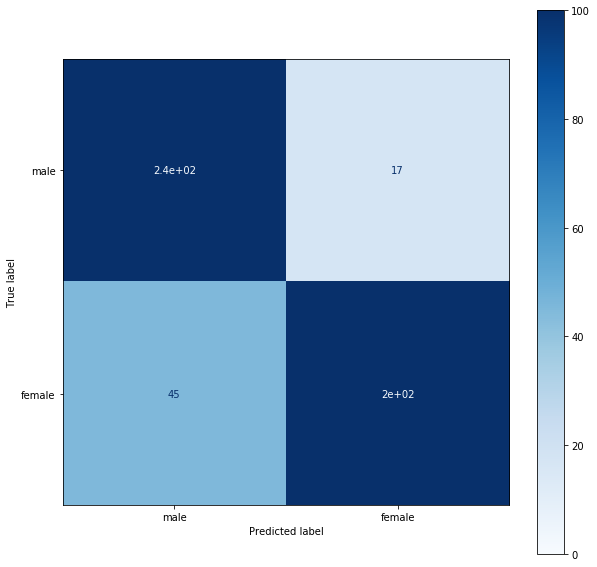

In [241]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array(['male', 'female']))
disp.plot(cmap='Blues') 
disp.ax_.get_images()[0].set_clim(0, 100)